Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'reg__regressor__max_depth': 17, 'reg__regressor__max_features': np.float64(0.7578185914055438), 'reg__regressor__max_samples': np.float64(0.9040601897822085), 'reg__regressor__min_samples_leaf': 1, 'reg__regressor__min_samples_split': 7, 'reg__regressor__n_estimators': 527}
Test MSE: 0.08519823859216764


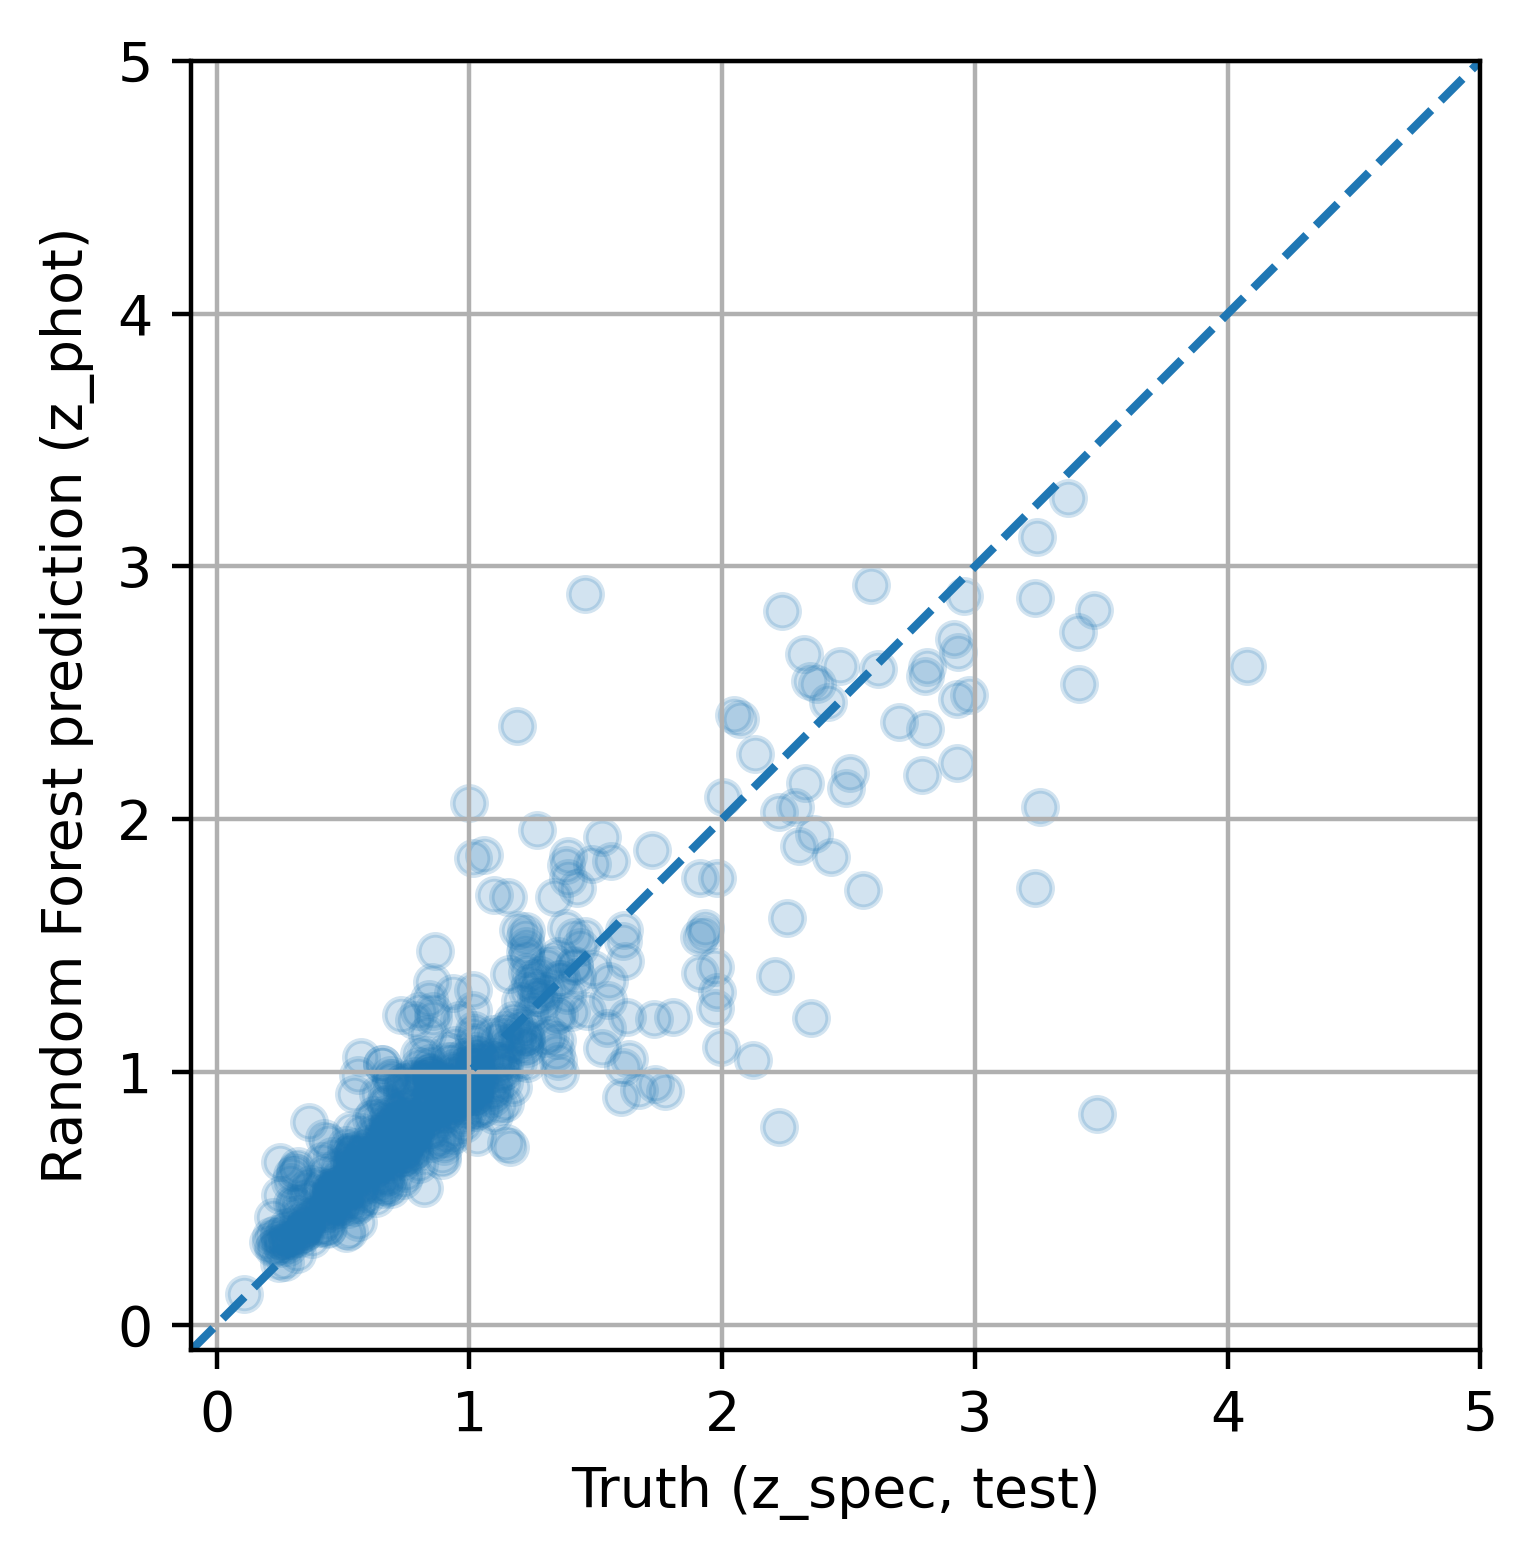

[Validation] Random Forest  MSE: 0.093463 | RMSE: 0.305717
[Validation] EAZY (z_peak)  MSE: 0.134827 | RMSE: 0.367189
[Validation] MSE ratio  (RF/EAZY): 0.693
[Validation] RMSE ratio (RF/EAZY): 0.833


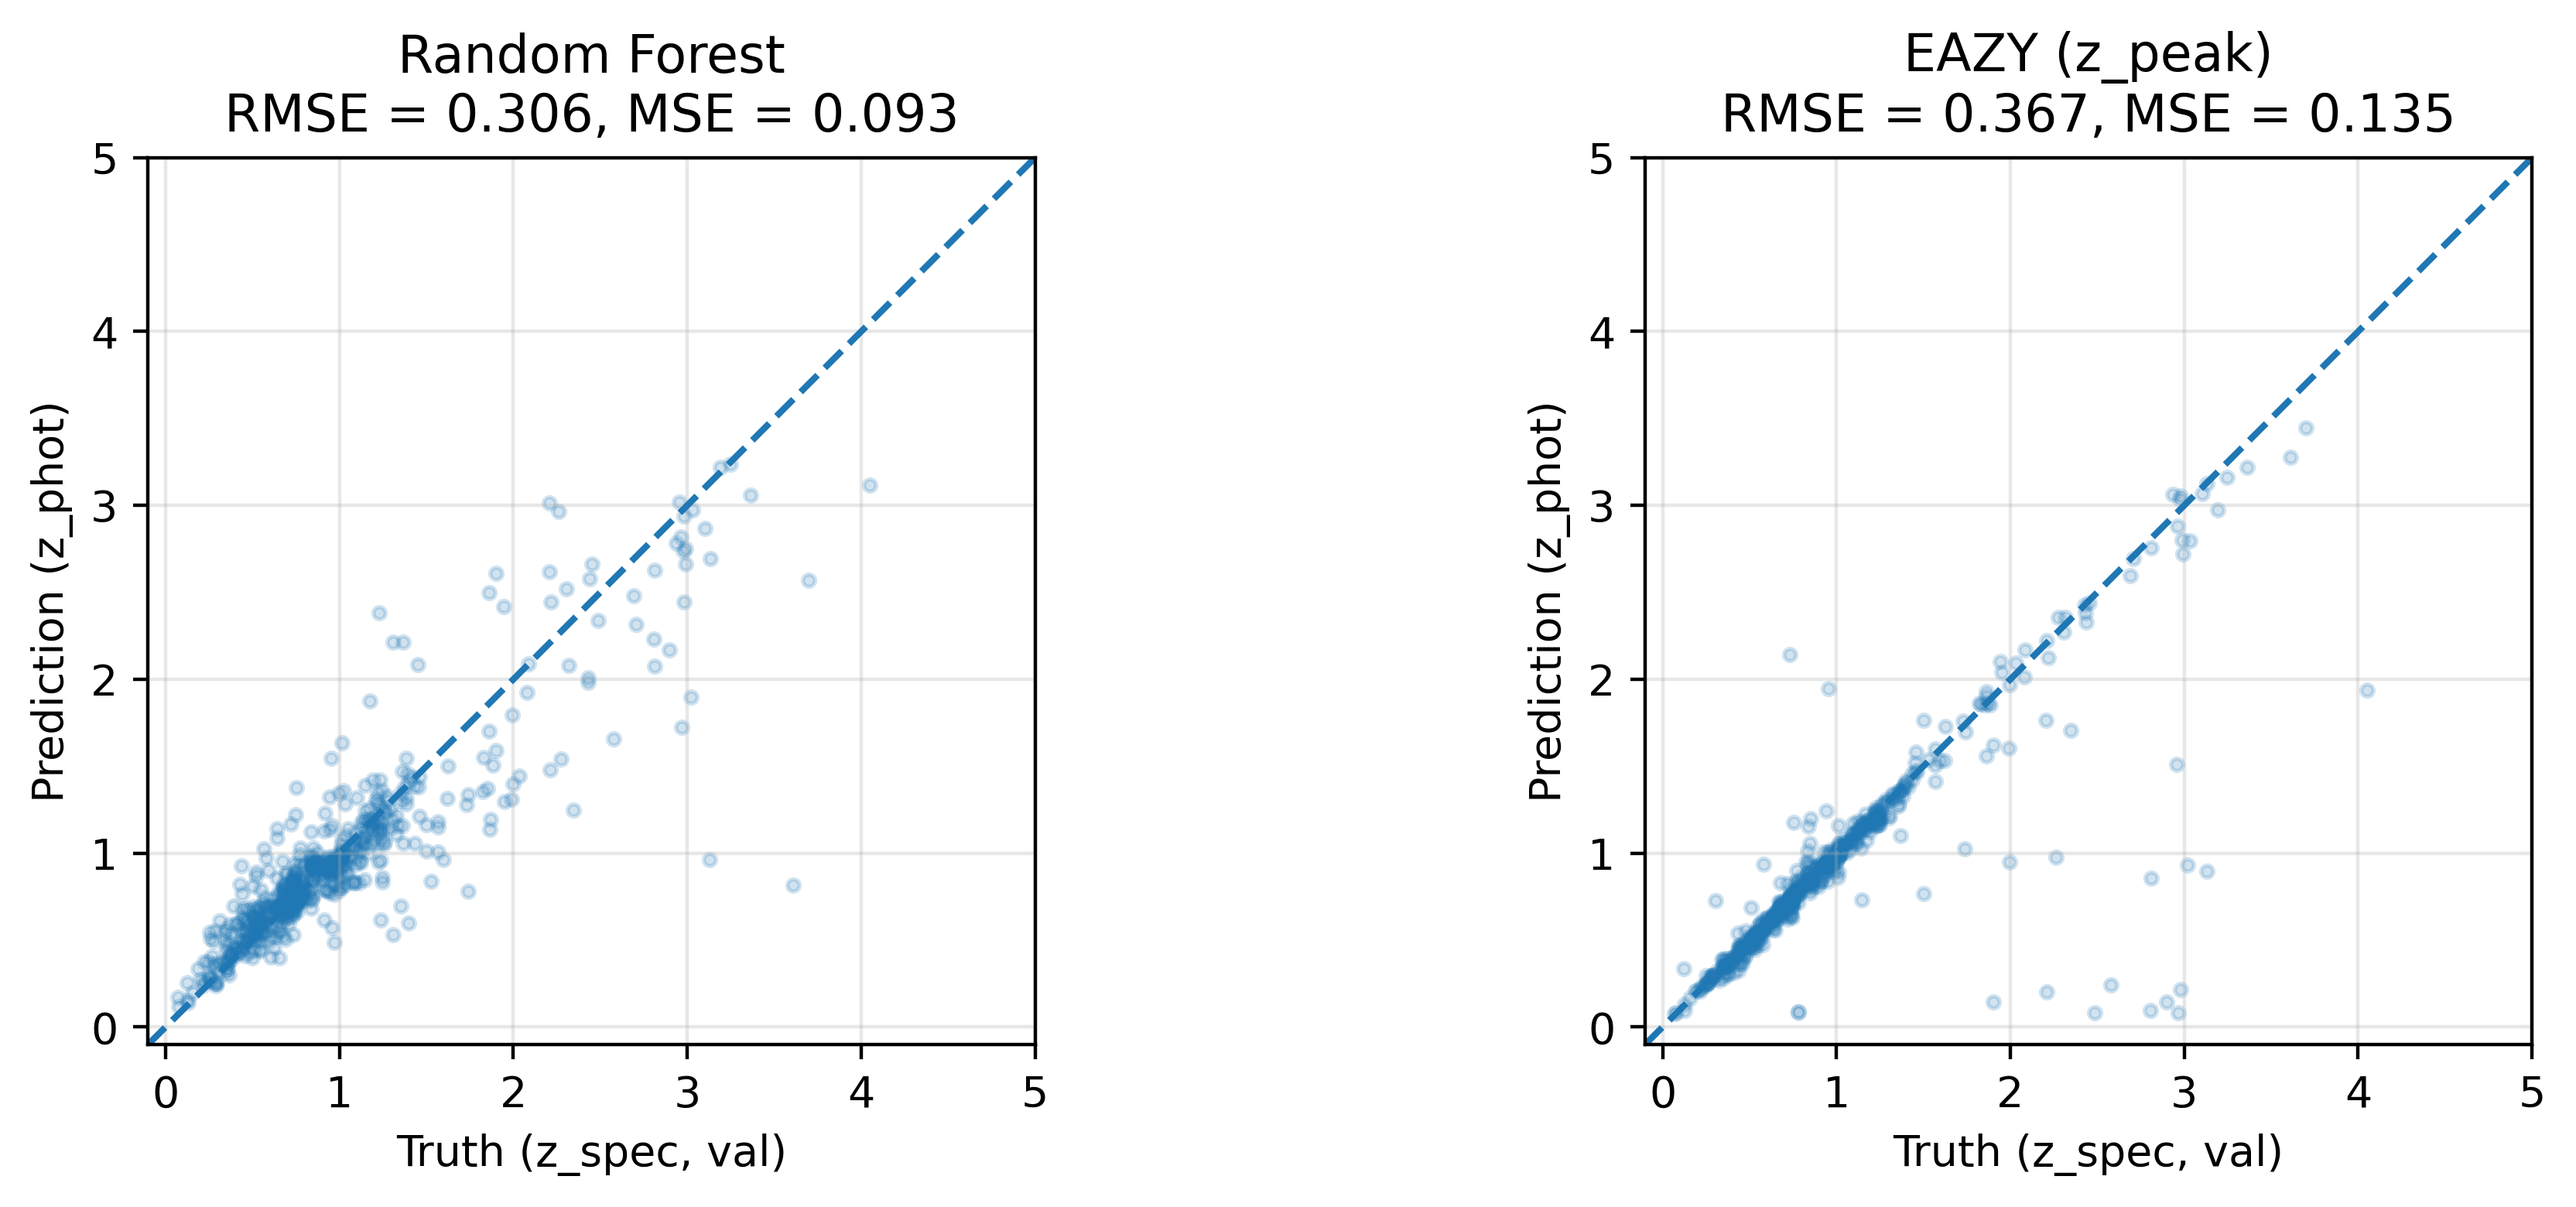

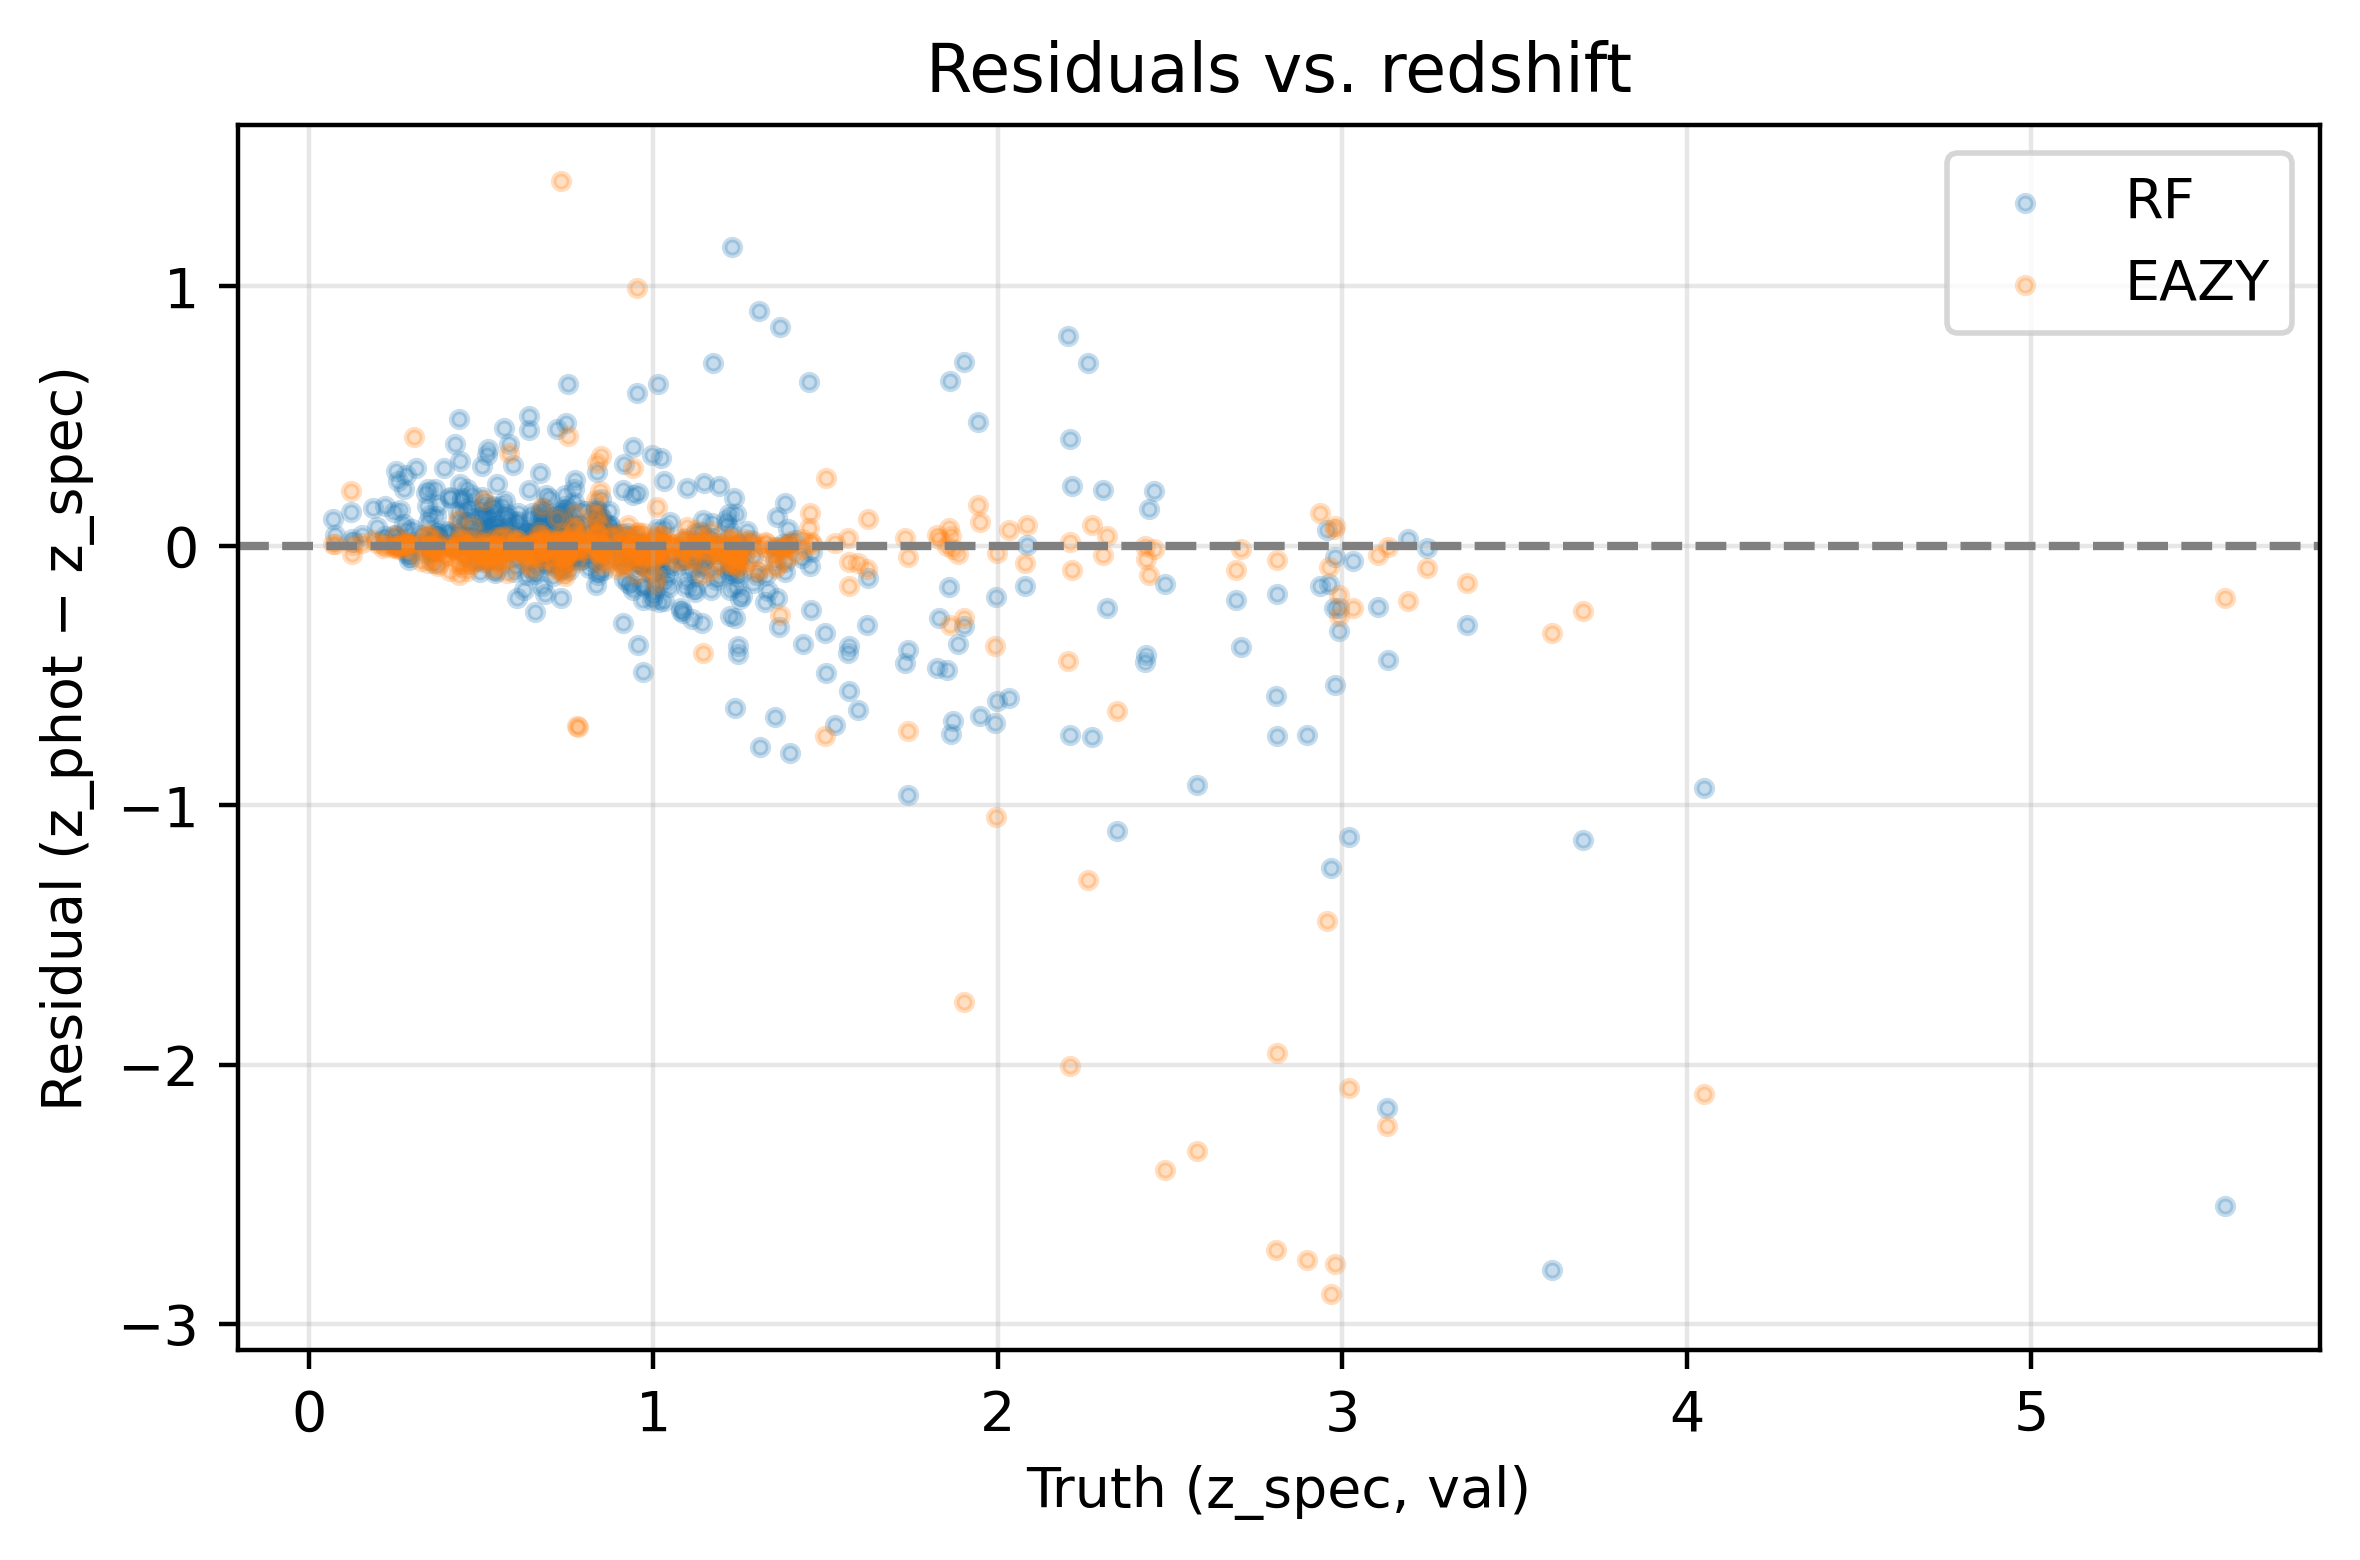

In [14]:
import itertools
import numpy as np
import tarfile
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -------------------------
# Load
# -------------------------
tab = Table.read('/Users/fengbocheng/Projects/Photometric-Redshifts/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat',
                 format='ascii').to_pandas()
target = 'z_spec'

# -------------------------
# 0) Basic quality cuts BEFORE feature engineering
# -------------------------
must_have = {'use_phot', 'z_spec'}
if must_have.issubset(tab.columns):
    mask = (tab['use_phot'] == 1) & (tab[target] > 0)
    if 'lmass' in tab.columns:
        mask &= (tab['lmass'] > 9)
    tab = tab[mask].copy()

# -------------------------
# 1) Clean error columns
# -------------------------
errors = [c for c in tab.columns if (c.startswith('e_') and c.endswith('W')) or c.startswith('eaper_')]
for e in errors:
    tab.loc[(~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90), e] = np.nan

# -------------------------
# 2) Transfer all fluxes to AB magnitudes (zeropoint = 25)
# -------------------------
bands = ['F606W', 'F814W', 'F140W', 'F160W', 'F125W']
for b in bands:
    fcol = f'f_{b}'
    if fcol in tab.columns:
        tab.loc[(~np.isfinite(tab[fcol])) | (tab[fcol] <= 0), fcol] = np.nan
        tab[f'mag_{b}'] = 25.0 - 2.5 * np.log10(np.clip(tab[fcol].to_numpy(), 1e-6, np.inf))

# -------------------------
# 3) Add color features: ALL pairwise colors (no duplicates)
# -------------------------
mag_cols = [f'mag_{b}' for b in bands if f'mag_{b}' in tab.columns]
for a, b in itertools.combinations(mag_cols, 2):
    band_a = a.replace('mag_', '')
    band_b = b.replace('mag_', '')
    tab[f'color_{band_a}_{band_b}'] = tab[a] - tab[b]

# -------------------------
# 4) Add axis ratio b/a (simple morphology)
# -------------------------
if {'a_image', 'b_image'}.issubset(tab.columns):
    tab['axis_ratio'] = tab['b_image'] / (tab['a_image'] + 1e-6)

# -------------------------
# 5) Assemble feature list 
# -------------------------
feature_cols = []
# magnitudes
for b in bands:
    c = f'mag_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# all pairwise colors
for a, b in itertools.combinations([bb for bb in bands if f'mag_{bb}' in tab.columns], 2):
    c = f'color_{a}_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# axis ratio (optional)
if 'axis_ratio' in tab.columns:
    feature_cols.append('axis_ratio')
# other scalar features (only add if present)
for extra in ['flux_radius', 'fwhm_image', 'kron_radius', 'tot_cor']:
    if extra in tab.columns:
        feature_cols.append(extra)

# -------------------------
# 5b) Add S/N features per band (if both flux & error exist)
# -------------------------
for b in bands:
    f = f"f_{b}"
    e = f"e_{b}"
    if f in tab.columns and e in tab.columns:
        sn = f"snr_{b}"
        tab[sn] = np.where((tab[e] > 0) & np.isfinite(tab[e]), tab[f]/tab[e], np.nan)
        if sn not in feature_cols:
            feature_cols.append(sn)

# -------------------------
# Build X (DataFrame) and y
# -------------------------
X = tab[feature_cols]   # DataFrame (keep names for ColumnTransformer)
y = tab[target].values
indices = np.arange(len(y))

# -------------------------
# 6) Stratified splits on binned z_spec
# -------------------------
n_bins = 10  # reduce if you get "least populated class has only 1 member"
quantiles = np.quantile(y, np.linspace(0, 1, n_bins + 1))
quantiles = np.unique(quantiles)
if len(quantiles) < 3:
    quantiles = np.quantile(y, np.linspace(0, 1, 6))  # 5 bins
y_bins_all = np.digitize(y, quantiles[1:-1], right=True)

# 6.1 Train vs temp (val+test)
X_train, X_temp, y_train, y_temp, indices_train, indices_temp, bins_train, bins_temp = train_test_split(
    X, y, indices, y_bins_all,
    test_size=0.30, random_state=42, stratify=y_bins_all
)

# 6.2 Temp → validation & test (50/50), stratified within temp
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(
    X_temp, y_temp, indices_temp,
    test_size=0.50, random_state=42, stratify=bins_temp
)

# -------------------------
# 7) Pipeline (no leakage) + log1p target + tuned RF
# -------------------------
pre = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median", add_indicator=True), feature_cols)],
    remainder="drop",
)

rf_base = RandomForestRegressor(
    random_state=42, n_jobs=-1, bootstrap=True, oob_score=True
)

pipe = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=rf_base, func=np.log1p, inverse_func=np.expm1
    )),
])

# Focused search on the knobs that matter
param_dist = {
    # trees: more is stabler; let the search pick a sweet spot
    "reg__regressor__n_estimators": randint(500, 1201),      # 500–1200
    # depth: you observed plateau ~12; search compact 6–20
    "reg__regressor__max_depth":    randint(6, 21),          # 6–20
    # feature subsampling: 0.2–0.8 often good (plus categorical options)
    "reg__regressor__max_features": uniform(0.2, 0.6),       # continuous 0.2–0.8
    # regularization knobs
    "reg__regressor__min_samples_leaf": randint(1, 9),       # 1–8
    "reg__regressor__min_samples_split": randint(2, 21),     # 2–20
    # bootstrap subsampling per tree to decorrelate trees
    "reg__regressor__max_samples":  uniform(0.5, 0.5),       # 0.5–1.0
}

rf_random = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30, cv=5, scoring="neg_mean_squared_error",
    random_state=42, verbose=1
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("Best params:", rf_random.best_params_)

# -------------------------
# 8) Evaluate on test set
# -------------------------
y_predict_test = best_rf.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_predict_test))

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=400)
ax.scatter(y_test, y_predict_test, alpha=0.2)
ax.plot([-0.1, 5], [-0.1, 5], linestyle='--')  # 1:1 line
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid(True)
ax.set_xlabel('Truth (z_spec, test)')
ax.set_ylabel('Random Forest prediction (z_phot)')
plt.tight_layout()
plt.show()

# -------------------------
# 9) Validation comparison vs Skelton+2014 z_peak
# -------------------------
z_ml   = best_rf.predict(X_validate)                   # ML (pipeline RF)
z_eazy = tab['z_peak'].to_numpy()[indices_validate]    # EAZY baseline
z_spec = y_validate                                    # ground truth

# MSE / RMSE and ratios (validation)
mse_ml  = mean_squared_error(z_spec, z_ml)
mse_ez  = mean_squared_error(z_spec, z_eazy)
rmse_ml = np.sqrt(mse_ml)
rmse_ez = np.sqrt(mse_ez)

print(f"[Validation] Random Forest  MSE: {mse_ml:.6f} | RMSE: {rmse_ml:.6f}")
print(f"[Validation] EAZY (z_peak)  MSE: {mse_ez:.6f} | RMSE: {rmse_ez:.6f}")
print(f"[Validation] MSE ratio  (RF/EAZY): {mse_ml / mse_ez:.3f}")
print(f"[Validation] RMSE ratio (RF/EAZY): {rmse_ml / rmse_ez:.3f}")

# Scatter: predictions vs. z_spec (RF & EAZY)
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)

ax[0].scatter(z_spec, z_ml, alpha=0.2, s=8)
ax[0].plot([-0.1, 5], [-0.1, 5], ls='--')
ax[0].set_aspect('equal'); ax[0].set_xlim(-0.1, 5); ax[0].set_ylim(-0.1, 5)
ax[0].grid(True, alpha=0.3)
ax[0].set_xlabel('Truth (z_spec, val)')
ax[0].set_ylabel('Prediction (z_phot)')
ax[0].set_title(f'Random Forest\nRMSE = {rmse_ml:.3f}, MSE = {mse_ml:.3f}')

ax[1].scatter(z_spec, z_eazy, alpha=0.2, s=8)
ax[1].plot([-0.1, 5], [-0.1, 5], ls='--')
ax[1].set_aspect('equal'); ax[1].set_xlim(-0.1, 5); ax[1].set_ylim(-0.1, 5)
ax[1].grid(True, alpha=0.3)
ax[1].set_xlabel('Truth (z_spec, val)')
ax[1].set_ylabel('Prediction (z_phot)')
ax[1].set_title(f'EAZY (z_peak)\nRMSE = {rmse_ez:.3f}, MSE = {mse_ez:.3f}')

plt.tight_layout()
plt.show()

# Residuals vs z_spec
res_rf = z_ml - z_spec
res_ez = z_eazy - z_spec

fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
ax.scatter(z_spec, res_rf, alpha=0.25, s=8, label='RF')
ax.scatter(z_spec, res_ez, alpha=0.25, s=8, label='EAZY')
ax.axhline(0, color='gray', ls='--')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Truth (z_spec, val)')
ax.set_ylabel('Residual (z_phot − z_spec)')
ax.set_title('Residuals vs. redshift')
ax.legend()

plt.tight_layout()
plt.show()

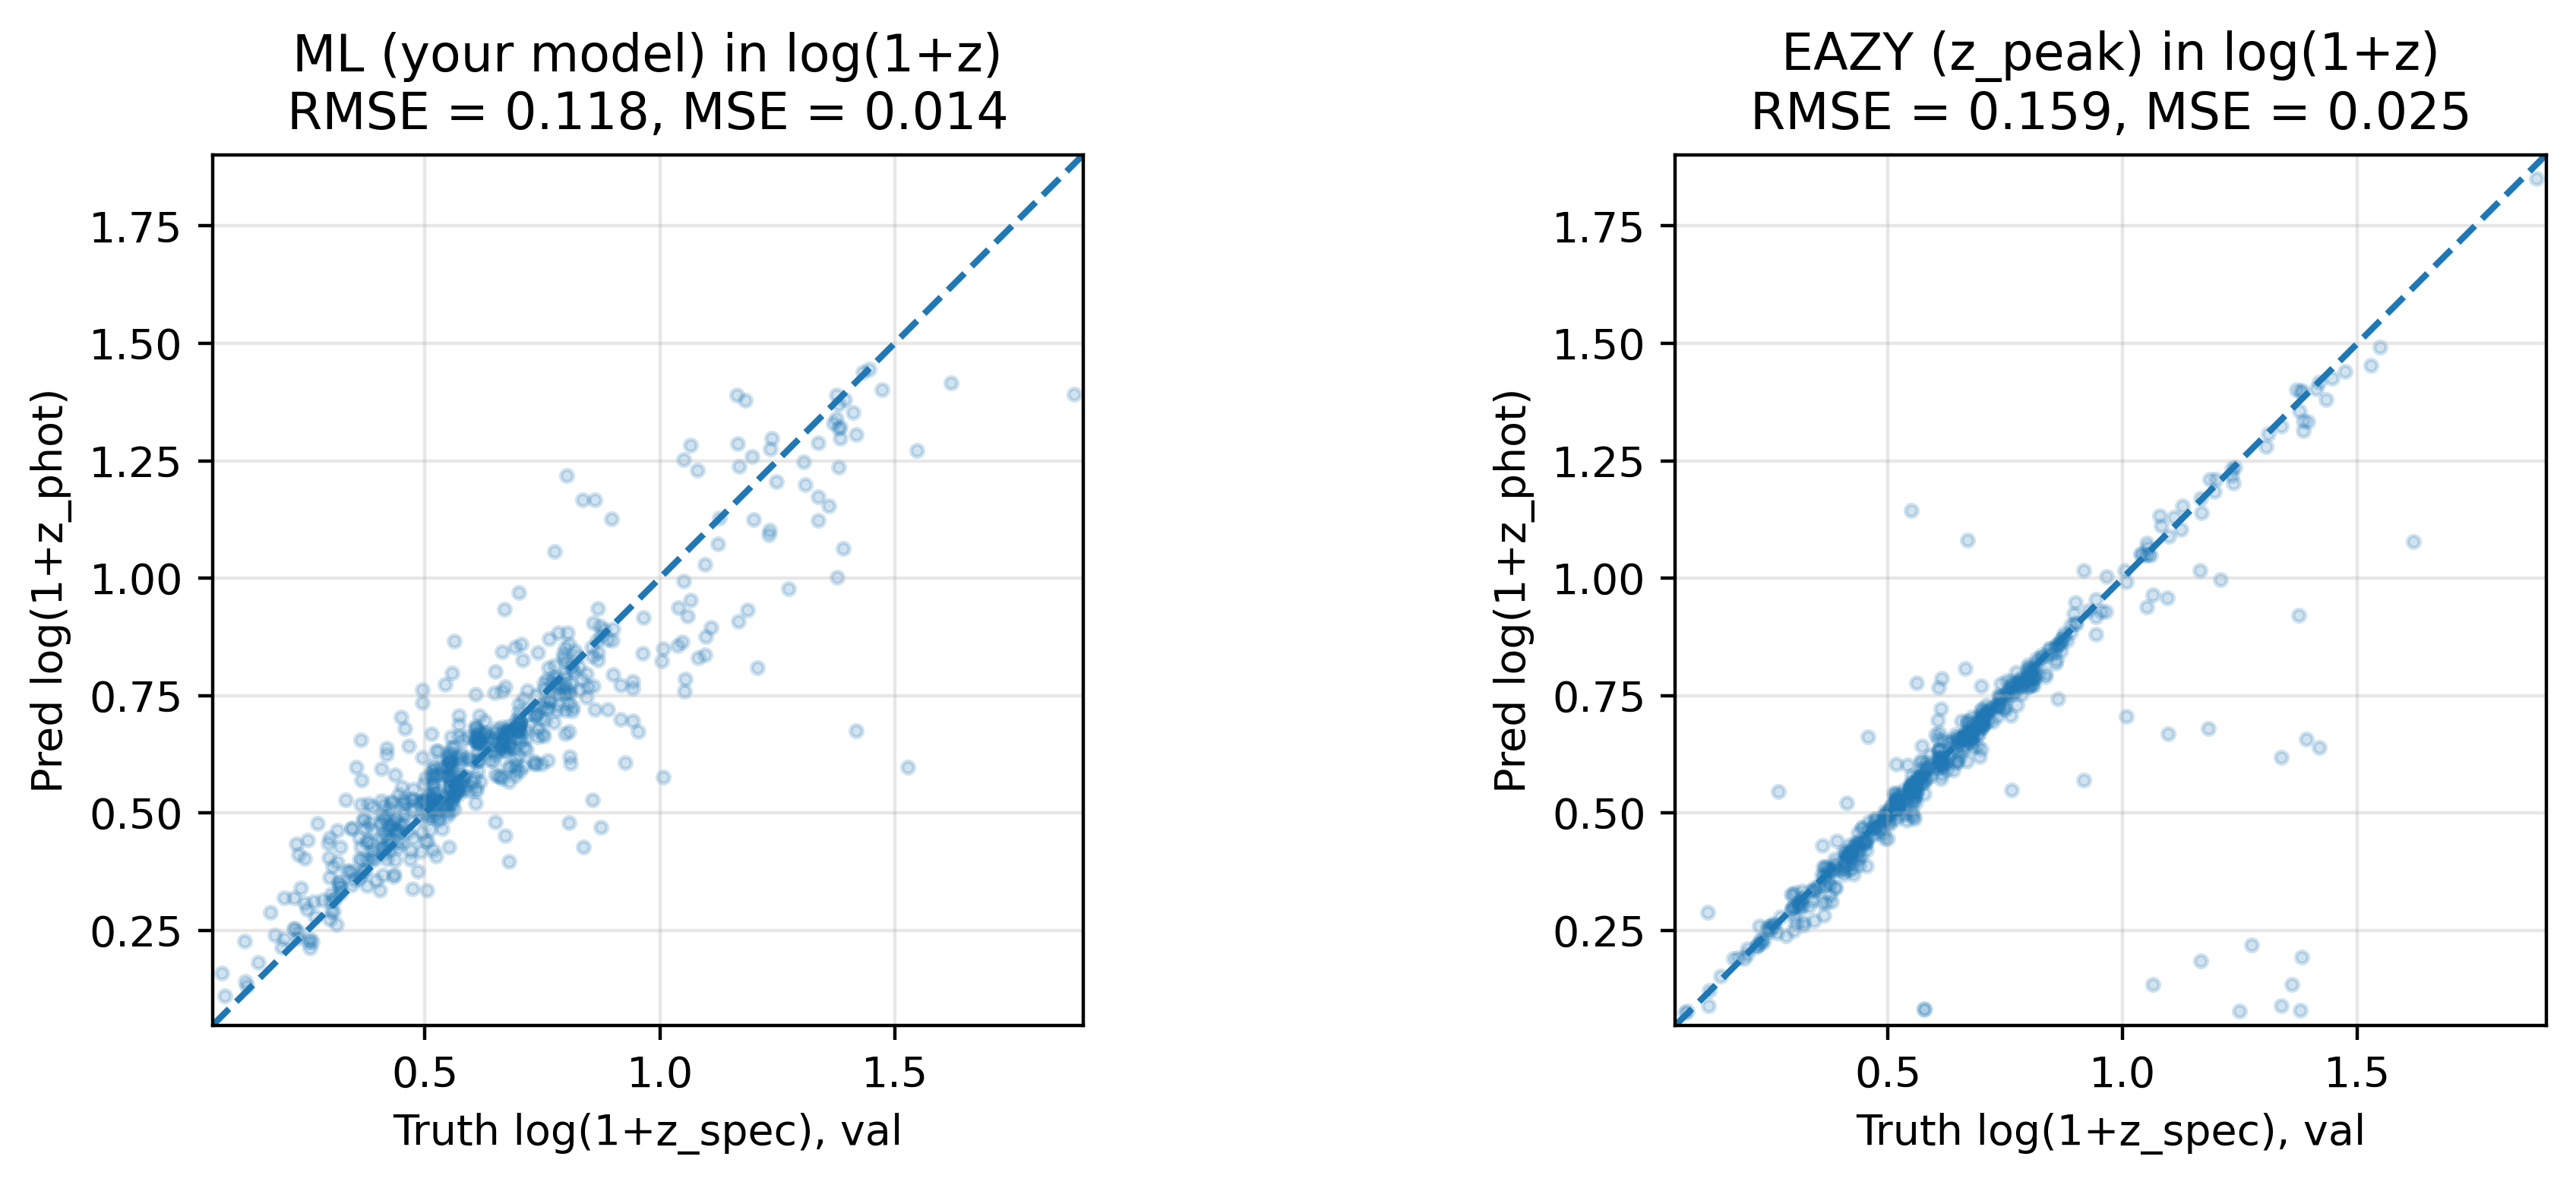

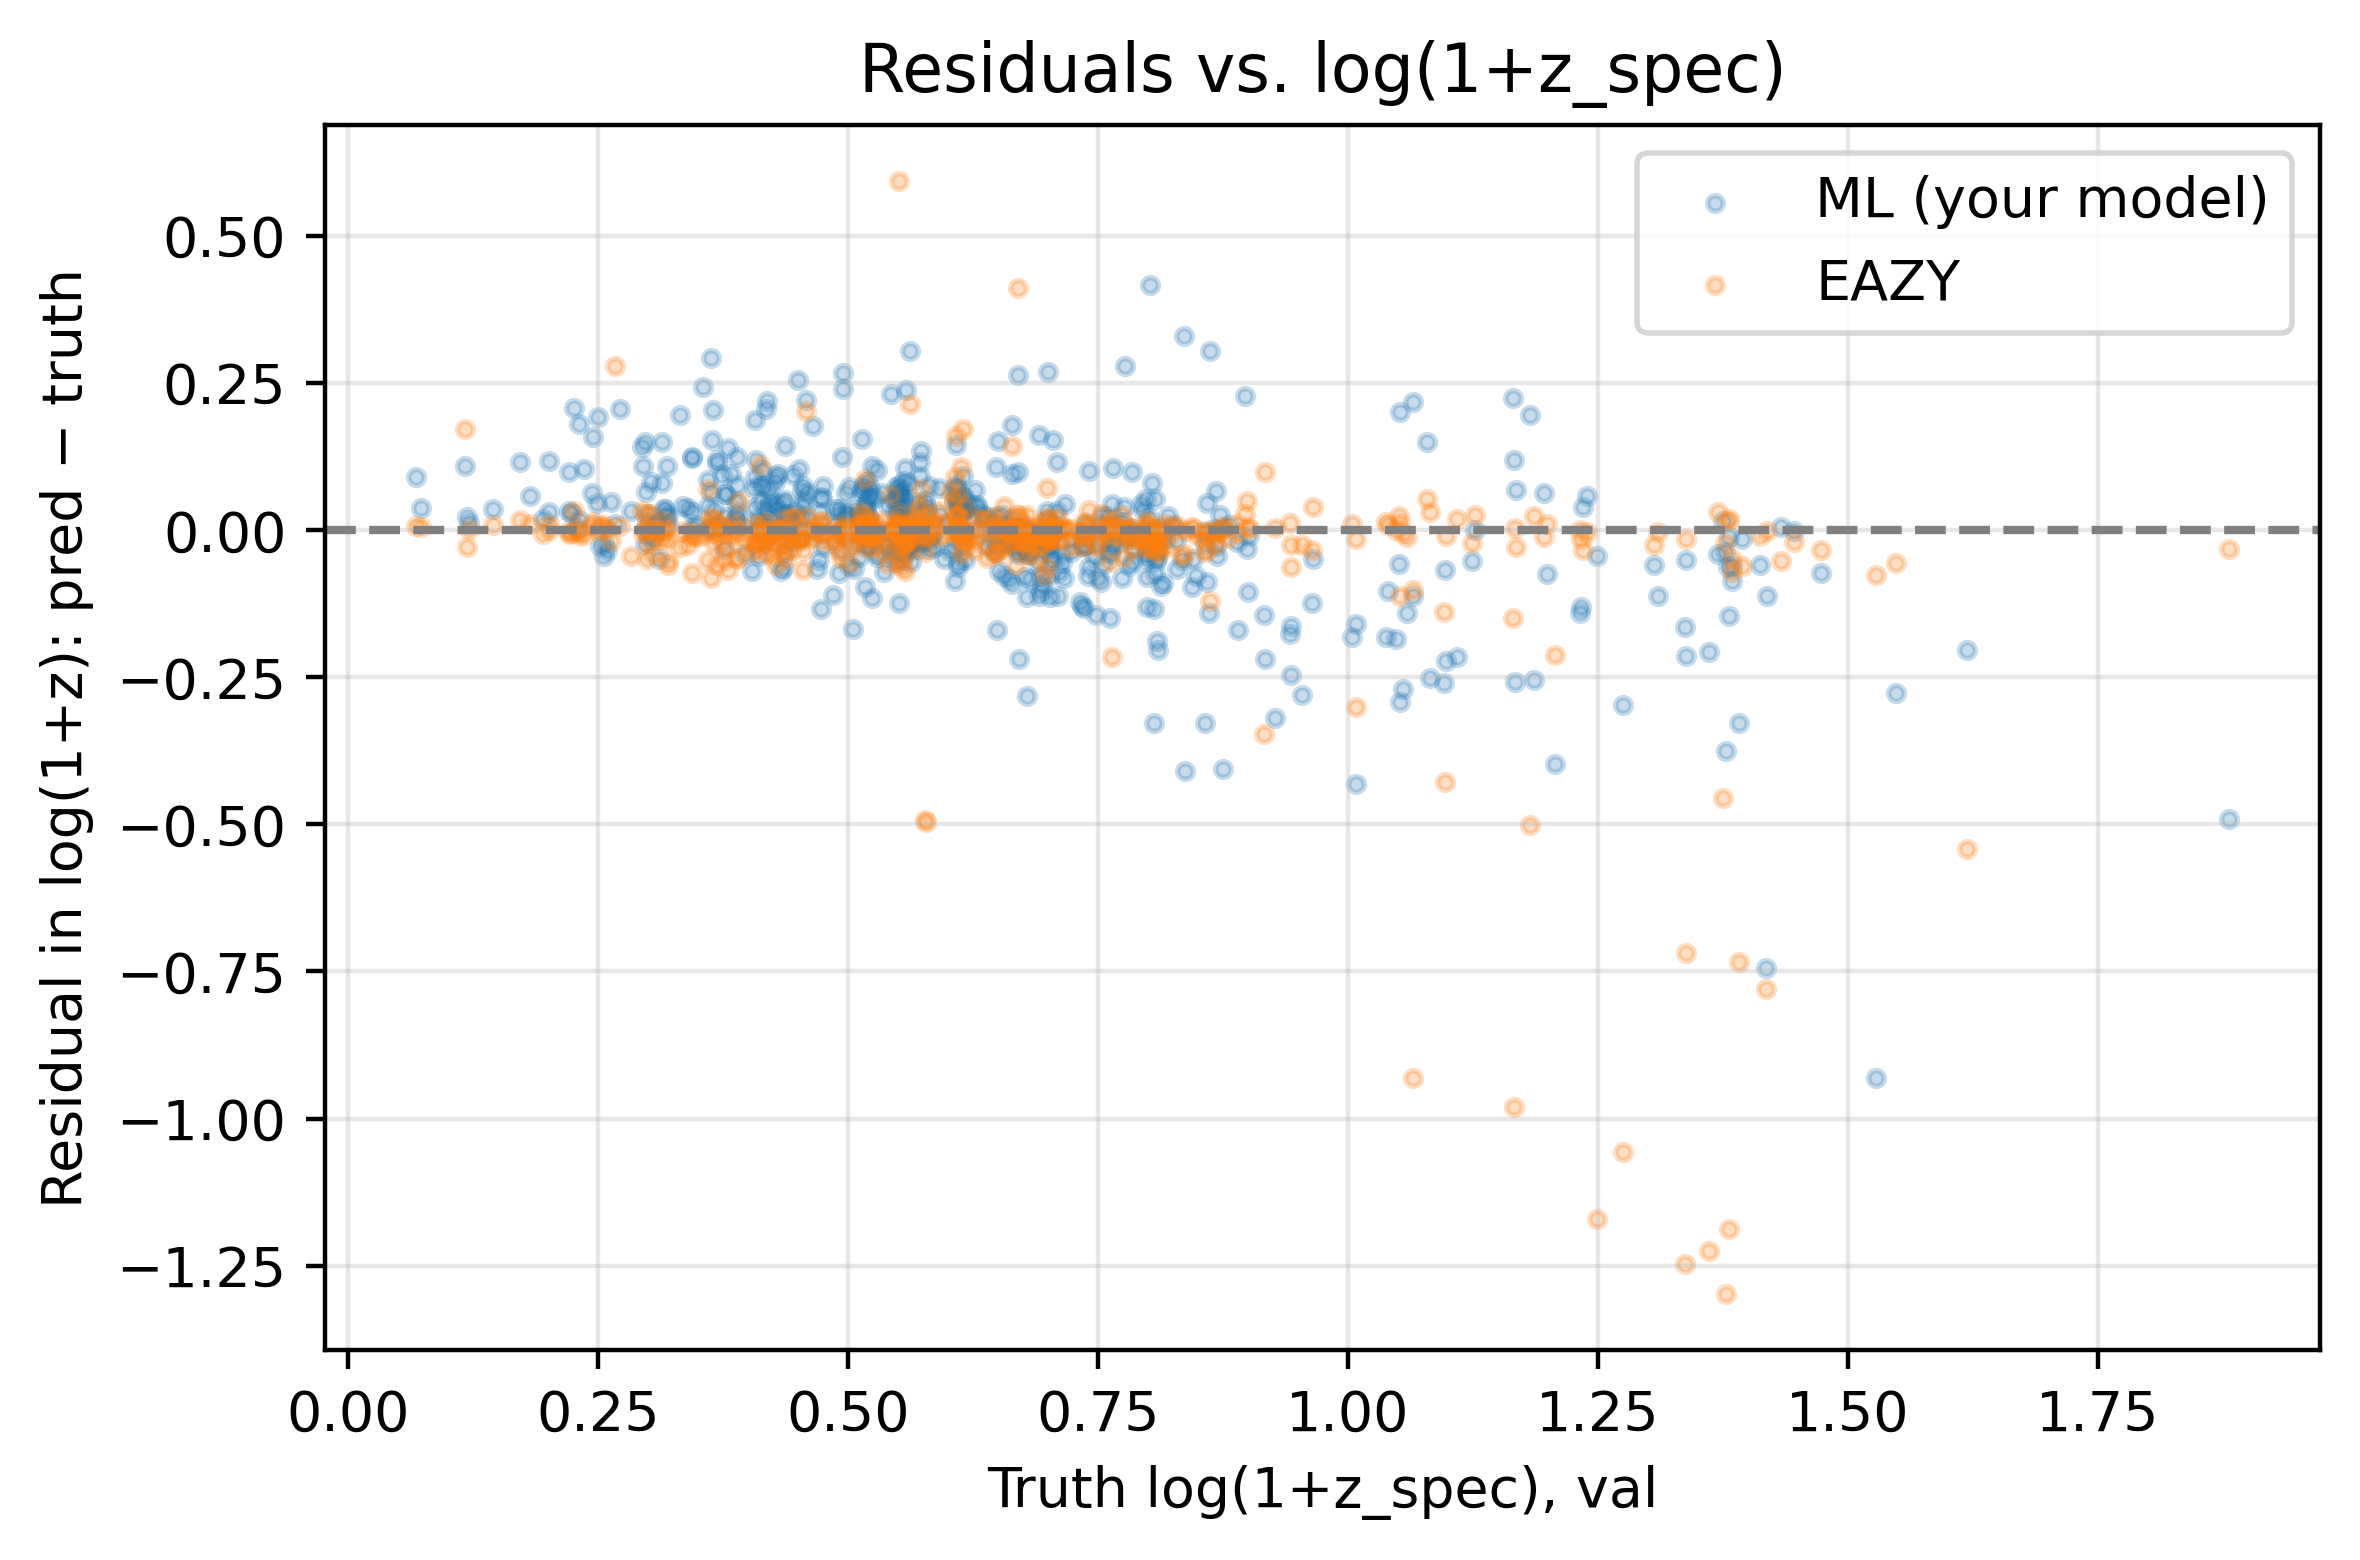

In [15]:
# =========================
# Extra panels in log(1+z)
# =========================
# Safe log1p (clip small negatives to 0)
z_spec_log  = np.log1p(np.clip(z_spec,  0, None))
z_ml_log    = np.log1p(np.clip(z_ml,    0, None))
z_eazy_log  = np.log1p(np.clip(z_eazy,  0, None))

# Compute RMSE/MSE in log-space (optional, for titles)
mse_ml_log  = mean_squared_error(z_spec_log, z_ml_log)
mse_ez_log  = mean_squared_error(z_spec_log, z_eazy_log)
rmse_ml_log = np.sqrt(mse_ml_log)
rmse_ez_log = np.sqrt(mse_ez_log)

# --- Scatter: predictions vs. truth in log(1+z) ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)

# Panel A: SVR/RF vs truth (log1p)
ax[0].scatter(z_spec_log, z_ml_log, alpha=0.2, s=8)
lims = [min(z_spec_log.min(), z_ml_log.min()) - 0.02,
        max(z_spec_log.max(), z_ml_log.max()) + 0.02]
ax[0].plot(lims, lims, ls='--')
ax[0].set_aspect('equal'); ax[0].set_xlim(lims); ax[0].set_ylim(lims)
ax[0].grid(True, alpha=0.3)
ax[0].set_xlabel('Truth log(1+z_spec), val')
ax[0].set_ylabel('Pred log(1+z_phot)')
ax[0].set_title(f'ML (your model) in log(1+z)\nRMSE = {rmse_ml_log:.3f}, MSE = {mse_ml_log:.3f}')

# Panel B: EAZY vs truth (log1p)
ax[1].scatter(z_spec_log, z_eazy_log, alpha=0.2, s=8)
lims = [min(z_spec_log.min(), z_eazy_log.min()) - 0.02,
        max(z_spec_log.max(), z_eazy_log.max()) + 0.02]
ax[1].plot(lims, lims, ls='--')
ax[1].set_aspect('equal'); ax[1].set_xlim(lims); ax[1].set_ylim(lims)
ax[1].grid(True, alpha=0.3)
ax[1].set_xlabel('Truth log(1+z_spec), val')
ax[1].set_ylabel('Pred log(1+z_phot)')
ax[1].set_title(f'EAZY (z_peak) in log(1+z)\nRMSE = {rmse_ez_log:.3f}, MSE = {mse_ez_log:.3f}')

plt.tight_layout()
plt.show()

# --- Residuals vs truth in log(1+z) ---
res_ml_log   = z_ml_log   - z_spec_log
res_eazy_log = z_eazy_log - z_spec_log

fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
ax.scatter(z_spec_log, res_ml_log,   alpha=0.25, s=8, label='ML (your model)')
ax.scatter(z_spec_log, res_eazy_log, alpha=0.25, s=8, label='EAZY')
ax.axhline(0, color='gray', ls='--')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Truth log(1+z_spec), val')
ax.set_ylabel('Residual in log(1+z): pred − truth')
ax.set_title('Residuals vs. log(1+z_spec)')
ax.legend()
plt.tight_layout()
plt.show()

In [13]:

# --- Photo-z metrics ---
def dz(z_phot, z_spec):
    """Normalized error Δz/(1+z_spec)."""
    return (z_phot - z_spec) / (1.0 + z_spec)

def nmad(z_phot, z_spec):
    """NMAD = 1.48 * median(|Δz - median(Δz)|)."""
    d = dz(z_phot, z_spec)
    med = np.median(d)
    return 1.48 * np.median(np.abs(d - med))

def outlier_frac(z_phot, z_spec, thr=0.15):
    """Fraction with |Δz| > thr (default 0.15)."""
    d = np.abs(dz(z_phot, z_spec))
    return np.mean(d > thr)

def bias_median(z_phot, z_spec):
    """Median bias in Δz (can show systematic offset)."""
    return np.median(dz(z_phot, z_spec))

nm_rf   = nmad(z_ml,   z_spec)
nm_ez   = nmad(z_eazy, z_spec)
fout_rf = outlier_frac(z_ml,   z_spec, thr=0.15)
fout_ez = outlier_frac(z_eazy, z_spec, thr=0.15)
bias_rf = bias_median(z_ml,   z_spec)
bias_ez = bias_median(z_eazy, z_spec)

print("[Validation] Random Forest")
print(f"  bias_med(Δz): {bias_rf:+.5f}")
print(f"  NMAD(Δz):     {nm_rf:.5f}")
print(f"  f_out(|Δz|>0.15): {fout_rf:.5f}")

print("\n[Validation] EAZY (z_peak)")
print(f"  bias_med(Δz): {bias_ez:+.5f}")
print(f"  NMAD(Δz):     {nm_ez:.5f}")
print(f"  f_out(|Δz|>0.15): {fout_ez:.5f}")

# (Optional) quick ratios
print("\nRatios (RF / EAZY):")
print(f"  NMAD ratio   : {nm_rf / nm_ez:.3f}")
print(f"  Outlier ratio: {fout_rf / fout_ez:.3f}")

[Validation] Random Forest
  bias_med(Δz): +0.00603
  NMAD(Δz):     0.07884
  f_out(|Δz|>0.15): 0.16107

[Validation] EAZY (z_peak)
  bias_med(Δz): -0.00331
  NMAD(Δz):     0.01794
  f_out(|Δz|>0.15): 0.05034

Ratios (RF / EAZY):
  NMAD ratio   : 4.394
  Outlier ratio: 3.200


In [11]:
from sklearn.metrics import mean_squared_error

# --- Training predictions ---
y_pred_train = best_rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

# --- Validation predictions (already computed as z_ml) ---
mse_val = mean_squared_error(y_validate, z_ml)
rmse_val = np.sqrt(mse_val)

# --- Test predictions (already computed as y_predict_test) ---
mse_test = mean_squared_error(y_test, y_predict_test)
rmse_test = np.sqrt(mse_test)

print(f"[Train] MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}")
print(f"[Val]   MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}")
print(f"[Test]  MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}")

[Train] MSE: 0.0336, RMSE: 0.1834
[Val]   MSE: 0.1101, RMSE: 0.3318
[Test]  MSE: 0.1045, RMSE: 0.3232


In [ ]:
# ================================
# Overfitting check: max_depth sweep
# ================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Depths to try (last one is "∞" i.e., None in sklearn)
depth_grid = [2, 4, 6, 8, 12, 16, 20, 30, 40, 50, None]
depth_labels = [str(d) if d is not None else "∞" for d in depth_grid]

mse_train_list = []
mse_test_list  = []
rmse_train_list = []
rmse_test_list  = []

# Reuse your best RF's settings except for max_depth
base_params = best_rf.get_params()
# Make sure we keep the same number of trees for a fair comparison
base_params.setdefault("n_estimators", 300)
base_params.setdefault("random_state", 42)
base_params.setdefault("n_jobs", -1)

for depth in depth_grid:
    params = base_params.copy()
    params["max_depth"] = depth
    rf_depth = RandomForestRegressor(**params)
    rf_depth.fit(X_train, y_train)

    # Train set error
    y_pred_tr = rf_depth.predict(X_train)
    mse_tr = mean_squared_error(y_train, y_pred_tr)
    mse_train_list.append(mse_tr)
    rmse_train_list.append(np.sqrt(mse_tr))

    # Test set error
    y_pred_te = rf_depth.predict(X_test)
    mse_te = mean_squared_error(y_test, y_pred_te)
    mse_test_list.append(mse_te)
    rmse_test_list.append(np.sqrt(mse_te))

# --- Plot MSE vs. max_depth (Train vs Test) ---
fig, ax = plt.subplots(figsize=(7, 4), dpi=400)
x = np.arange(len(depth_grid))

ax.plot(x, mse_train_list, "o-", label="Train MSE")
ax.plot(x, mse_test_list,  "o-", label="Test MSE")
ax.set_xticks(x)
ax.set_xticklabels(depth_labels)
ax.set_xlabel("max_depth")
ax.set_ylabel("MSE")
ax.set_title("Random Forest: MSE vs. max_depth")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) Print a small table with RMSE too
print("max_depth | Train MSE  | Test MSE   | Train RMSE | Test RMSE")
for d, mtr, mte, rtr, rte in zip(depth_labels, mse_train_list, mse_test_list, rmse_train_list, rmse_test_list):
    print(f"{d:>8} | {mtr:10.4f} | {mte:10.4f} | {rtr:10.4f} | {rte:10.4f}")